In [261]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg as la

In [262]:
import seaborn as sn
import matplotlib.font_manager as fm

In [292]:
font_path = "/Users/pedrobraga/Documents/Cambridge/wa_two/cmunci.ttf"
custom_font = fm.FontProperties(fname=font_path)
plt.rcParams["font.family"] = custom_font.get_name()
sn.set(font=custom_font.get_name())

sn.set_theme(context='notebook', style='darkgrid', palette='deep', font_scale=1, color_codes=True, rc=None)

In [264]:
# --- global variables --- #

''' hbar = .658 # eV fs
c = 299.792 # nm fs{-1}

m0 = 5109980 # eV -> this is wrong there's an extra zero that should not be here
mu = .108 * m0 # eV

veps0 = 55.26 # e{2} eV{-1} mum{-1}
vepsS = 3.32 # dimless
vepsW = 6.10 # dimless

Lwell = 0.636 # nm
r0 = Lwell * (vepsW/(2*vepsS)) # nm

A = 1000/(8*(np.pi**2)*veps0*vepsS) # eV nm '''

hbar = 0.658 # eV fs
m0 = 5.6856800 # fs{2] eV nm{-2} 
mu = 0.108 * m0 # eV

veps0 = 5.52638e-2 # c{2} eV{-1} mum{-1}
vepsS = 3.32 # dimless
vepsW = 6.10 # dimless

Lwell = 0.636 # nm
r0 = Lwell * vepsW/(2*vepsS) # nm

A = Lwell**2 # eV nm


In [265]:
# --- simulation parameters --- #

k_max = .75
N = 500
dk = k_max/N

k_vals = np.linspace(dk, k_max, N)

th_max = 2*np.pi
Th = 250
dth = th_max/Th

cos_vals = np.cos(np.linspace(dth, th_max, Th))

In [266]:
def RytovaKeldysh(ki, kj): # Riemann sum over thetas

    if ki == kj:
        q = np.sqrt(ki**2 + kj**2 - 2*ki*kj*cos_vals[:-1]) # to deal with discontinuity just ignore cos(theta) = 1
    else:
        q = np.sqrt(ki**2 + kj**2 - 2*ki*kj*cos_vals)

    Vl = 1/(q * (1 + r0*q))
    Constants = 1 /(2 * veps0 * vepsS * Lwell**2)

    V = np.sum(Vl) * Constants

    return dth * A * V / (4 * np.pi**2)

In [267]:
def Coulomb(): # Riemann sum of the kj components

    V = np.zeros((N, N))

    for i in range(N):
        for j in range(N):
               
            V[i][j] = dk * k_vals[j] * RytovaKeldysh(k_vals[i], k_vals[j])

    return V

In [268]:
def WannierMatrix(): # construction of the Wannier matrix

    K = np.diag( hbar**2 * k_vals**2/(2 * mu) )

    H = K - Coulomb()

    np.savetxt("Hamiltonian.txt", H, fmt="%.10f")
    np.savetxt("Kinetic.txt", K, fmt="%.10f")
    np.savetxt("Coulomb.txt", Coulomb(), fmt="%.10f")

    return H

In [269]:
eigenvalues, eigenvectors = np.linalg.eig(WannierMatrix())
eigenvalues_SCP, eigenvectors_SCP = la.eig(WannierMatrix())

In [270]:
def EigenvectorsNorm(eigvec):

    Nv = np.zeros((N,N))

    # Similar to josh's
    for i in range(N):

        norm = 0
        for j in range(N):
            norm += 1/(2*np.pi)*k_vals[j]*dk*np.absolute(eigvec[j,i])**2 # calculate the integral on kj over |eigenfunction(ki,kj)|^2 considering the constants

        for j in range(N):
            Nv[j,i] = eigvec[j,i] / np.sqrt(norm) # divide each of the eigenfunctions by the required constant norm to get it over one'''

    np.savetxt('NVectors.txt', Nv, fmt="%.10f")

    return Nv

        

In [271]:
def Sorting(values): # making sure we are printing the eigenvectors for the lowest eigenvalues

    eigenvaluesDict = {value: index for index, value in enumerate(eigenvalues, start=0)}
    sortedEigenvalues = sorted(eigenvalues)

    output = np.zeros(5) # indexes of the correct eigenvectors

    for i in range(5):
        output[i] = eigenvaluesDict[sortedEigenvalues[i]]

    return output

In [272]:
norm_eigenvectors = EigenvectorsNorm(eigenvectors_SCP)

In [273]:
indexes = Sorting(eigenvalues)

In [274]:
s1 = int(indexes[0])
s2 = int(indexes[1])
s3 = int(indexes[2])
s4 = int(indexes[3])
s5 = int(indexes[4])

In [275]:
levels = [s1, s2, s3, s4, s5]

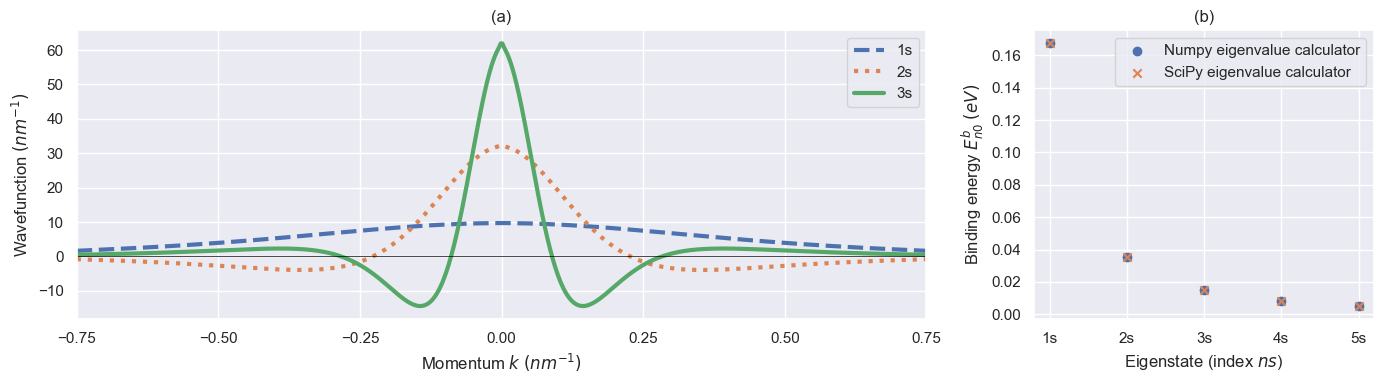

In [296]:
plot_x = np.concatenate((np.flip((-1) * k_vals), k_vals))

fig, axes = plt.subplots(1, 2, figsize=(14, 4), gridspec_kw={'width_ratios': [10, 4]})

# --- numpy eigenvalues function --- #

axes[0].plot(plot_x, np.concatenate((np.flip(norm_eigenvectors[:, s1]), norm_eigenvectors[:, s1])), label=f'1s', linewidth=3, linestyle='--')
axes[0].plot(plot_x, np.concatenate((np.flip(norm_eigenvectors[:, s2]), norm_eigenvectors[:, s2])), label=f'2s', linewidth=3, linestyle=':')
axes[0].plot(plot_x, np.concatenate((np.flip(norm_eigenvectors[:, s3]), norm_eigenvectors[:, s3])), label=f'3s', linewidth=3)
axes[0].plot(plot_x, np.zeros(len(plot_x)), c='black', linewidth=0.5)
axes[0].set_xticks([-0.75, -0.5, -0.25, 0, 0.25, 0.5, 0.75])

axes[0].set_xlabel('Momentum $k$ $(nm^{-1})$')
axes[0].set_xlim(-.75, .75)
axes[0].set_ylabel('Wavefunction $(nm^{-1})$')
axes[0].set_title('(a)')
axes[0].legend(loc='upper right')

axes[1].scatter(['1s', '2s' , '3s' , '4s', '5s'], eig_levels, label='Numpy eigenvalue calculator')
axes[1].scatter(['1s', '2s' , '3s' , '4s', '5s'], eig_levels, label='SciPy eigenvalue calculator', marker='x')
axes[1].set_xlabel('Eigenstate (index $ns$)')
axes[1].set_ylabel('Binding energy $E_{n0}^b$ $(eV)$')
axes[1].set_title('(b)')

axes[1].legend()

plt.tight_layout()
plt.savefig('eigen_results.png', dpi=500)

In [277]:
eig_levels = [(-1)* eigenvalues[s1],(-1)*  eigenvalues[s2],(-1)*  eigenvalues[s3],(-1)*  eigenvalues[s4],(-1)*  eigenvalues[s5]]